In [ ]:
from google.colab import drive
drive.mount("/gdrive", force_remount=True)

Mounted at /gdrive


In [ ]:
import sys
import os
root_dir = "/gdrive/MyDrive/8-2.Syntactic Parsing"
sys.path.append(root_dir)


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 66.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.3 MB/s eta 0:00:00


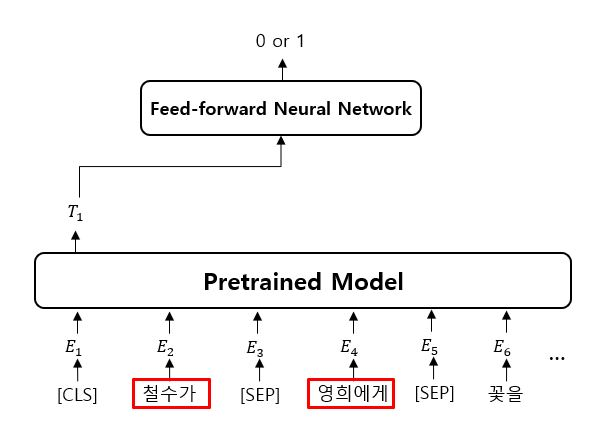

In [ ]:
from IPython.display import Image
Image(os.path.join(root_dir, "SyntacticParsing.JPG"))

In [ ]:
import torch
import torch.nn as nn

from transformers import ElectraPreTrainedModel, ElectraModel

class ElectraForSequenceClassification(ElectraPreTrainedModel):

    def __init__(self, config):
        super(ElectraForSequenceClassification, self).__init__(config)

        # Electra 모델
        self.electra = ElectraModel(config)

        # 분류할 라벨의 개수
        self.num_labels = config.num_labels
        
        self.hidden_size = config.hidden_size
        self.output_layer = nn.Linear(in_features=self.hidden_size, out_features=self.num_labels)

    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.electra(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # electra_output : (batch_size, max_length, hidden_size)
        electra_output = outputs[0]

        # cls_vector : (batch_size, hidden_size)
        cls_vector = electra_output[:, 0, :]

        # outputs : (batch_size, num_labels)
        outputs = self.output_layer(cls_vector)

        return outputs

In [ ]:

import torch
import numpy as np
import re
from tqdm import tqdm

label2idx = {"1":1, "0":0}
idx2label = {1:'1', 0:'0'}
def read_data(file_path):
    with open(file_path, "r", encoding="utf8") as infile:
        datas = []
        for line in infile:
            # 입력 데이터를 \t을 기준으로 분리
            pieces = line.strip().split("#%#")
            stack, top, bottom, queue, label = pieces[0], pieces[1], pieces[2], pieces[3], pieces[4]
            datas.append((stack, top, bottom, queue, label))
    return datas


def convert_data2feature(datas, max_length, tokenizer, label2idx):
    input_ids_features, attention_mask_features, token_type_ids_features, label_id_features = [], [], [], []

    for stack, stack_top, queue_bottom, queue, label in tqdm(datas, desc="convert_data2feature"):
        # Electra tokenizer를 사용하여 입력 문장을 word piece 단위로 분리
        tokenized_stack = tokenizer.tokenize(stack)
        tokenized_stack_top = tokenizer.tokenize(stack_top)
        tokenized_queue_bottom = tokenizer.tokenize(queue_bottom)
        tokenized_queue = tokenizer.tokenize(queue)


        # CLS, SEP 토큰 추가
        tokens = [tokenizer.cls_token]
        tokens += tokenized_stack
        tokens += [tokenizer.sep_token]
        tokens += tokenized_stack_top
        tokens += [tokenizer.sep_token]
        tokens += tokenized_queue_bottom
        tokens += [tokenizer.sep_token]
        tokens += tokenized_queue
        tokens += [tokenizer.sep_token]

        # word piece들을 대응하는 index로 치환
        input_ids = tokenizer.convert_tokens_to_ids(tokens)[:max_length]
        # padding을 제외한 실제 데이터 정보를 반영해주기 위한 attention mask
        attention_mask = [1] * len(input_ids)
        # 각 문장을 구분하기 위한 정보를 반영해주기 위한 token type
        token_type_ids = [0] * len(input_ids)

        # padding 생성
        padding = [tokenizer._convert_token_to_id(tokenizer.pad_token)] * (max_length - len(input_ids))
        input_ids += padding
        attention_mask += padding
        token_type_ids += padding
        assert max_length == len(input_ids) == len(attention_mask) == len(token_type_ids)


        label_id = label2idx[label]

        # 변환한 데이터를 각 리스트에 저장
        input_ids_features.append(input_ids)
        attention_mask_features.append(attention_mask)
        token_type_ids_features.append(token_type_ids)
        label_id_features.append(label_id)

    # 변환한 데이터를 Tensor 객체에 담아 반환
    input_ids_features = torch.tensor(input_ids_features, dtype=torch.long)
    attention_mask_features = torch.tensor(attention_mask_features, dtype=torch.long)
    token_type_ids_features = torch.tensor(token_type_ids_features, dtype=torch.long)
    label_id_features = torch.tensor(label_id_features, dtype=torch.long)

    return input_ids_features, attention_mask_features, token_type_ids_features, label_id_features

In [ ]:

import os
import numpy as np
from tqdm import tqdm


import torch
from torch.utils.data import (DataLoader, TensorDataset, RandomSampler, SequentialSampler)
import torch.optim as optim

from transformers import ElectraPreTrainedModel, ElectraTokenizer, ElectraConfig
from sklearn.metrics import accuracy_score

def train(config):
    # Electra tokenizer 객체 생성
    electra_tokenizer = ElectraTokenizer.from_pretrained(config['pretrained_model_name_or_path'])

    # 학습 및 평가 데이터 읽기
    train_datas = read_data(config["train_data_path"])
    test_datas = read_data(config["test_data_path"])

    # 입력 데이터 전처리
    train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features = \
        convert_data2feature(train_datas, config["max_length"], electra_tokenizer, label2idx)
    test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
        convert_data2feature(test_datas, config["max_length"], electra_tokenizer, label2idx)

    # 학습 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    train_features = TensorDataset(train_input_ids_features, train_attention_mask_features, train_token_type_ids_features, train_label_id_features)
    train_dataloader = DataLoader(train_features, sampler=RandomSampler(train_features), batch_size=config["batch_size"])

    # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
    test_features = TensorDataset(test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features)
    test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features), batch_size=config["batch_size"])

    # 사전 학습된 Electra 모델 파일로부터 가중치 불러옴
    electra_config = ElectraConfig.from_pretrained(config['pretrained_model_name_or_path'])
    model = ElectraForSequenceClassification.from_pretrained(config['pretrained_model_name_or_path'], config=electra_config).cuda()

    # loss를 계산하기 위한 함수
    loss_func = nn.CrossEntropyLoss()

    # 모델 학습을 위한 optimizer
    optimizer = optim.Adam(model.parameters(), lr=5e-5)

    # 모델의 정확도를 저장하기 위한 변수
    max_accuracy = 0
    global_step = 0
    for epoch in range(config["epoch"]):
        model.train()

        total_loss = []
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.cuda() for t in batch)
            input_ids, attention_mask, token_type_ids, label_id = batch

            # 역전파 단계를 실행하기 전에 변화도를 0으로 변경
            optimizer.zero_grad()

            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)

            # loss 계산
            loss = loss_func(hypothesis, label_id)

            # loss 값으로부터 모델 내부 각 매개변수에 대하여 gradient 계산
            loss.backward()
            # 모델 내부 각 매개변수 가중치 갱신
            optimizer.step()

            if (global_step + 1) % 10 == 0:
                print("Current {} Step Loss : {}".format(global_step+1, loss))
            if (global_step+1) % 200 == 0:
                electra_config.save_pretrained(save_directory=config["output_dir_path"])
                model.save_pretrained(save_directory=config["output_dir_path"])
                max_accuracy = evaluate(model, electra_tokenizer, test_dataloader, step, max_accuracy)
            global_step += 1
def evaluate(model, tokenizer, test_dataloader=None, global_step=0, max_accuracy=0):
    if not test_dataloader:
        test_datas = read_data(config["test_data_path"])

        # 입력 데이터 전처리
        test_input_ids_features, test_attention_mask_features, test_token_type_ids_features, test_label_id_features = \
            convert_data2feature(test_datas, config["max_length"], tokenizer, label2idx)

        # 평가 데이터를 batch 단위로 추출하기 위한 DataLoader 객체 생성
        test_features = TensorDataset(test_input_ids_features, test_attention_mask_features,
                                      test_token_type_ids_features, test_label_id_features)
        test_dataloader = DataLoader(test_features, sampler=SequentialSampler(test_features),
                                     batch_size=config["batch_size"])
    model.eval()

    # 모델의 출력 결과와 실제 정답값을 담을 리스트
    total_hypothesis, total_labels = [], []
    for idx, batch in enumerate(test_dataloader):
        batch = tuple(t.cuda() for t in batch)
        input_ids, attention_mask, token_type_ids, label_id = batch

        with torch.no_grad():
            # 모델 예측 결과
            hypothesis = model(input_ids, attention_mask, token_type_ids)
            # 모델의 출력값에 softmax와 argmax 함수를 적용
            hypothesis = torch.argmax(hypothesis, dim=-1)

        # Tensor를 리스트로 변경
        hypothesis = hypothesis.cpu().detach().numpy().tolist()
        label_id = label_id.cpu().detach().numpy().tolist()

        total_hypothesis += hypothesis
        total_labels += label_id

        if idx < 10:
            input_ids = tokenizer.convert_ids_to_tokens(input_ids[0].tolist())
            input_sequence = tokenizer.convert_tokens_to_string(input_ids[1:input_ids.index(tokenizer.pad_token)] if tokenizer.pad_token in input_ids else input_ids[1:])
            stack, top, bottom, queue, _ = [e.strip() for e in input_sequence.split("[SEP]")]
            print("\nStack : ", stack)
            print("Stack Top : ", top)
            print("Queue Bottom : ", bottom)
            print("Queue : ", queue)
            print("Prediction : ", hypothesis[0])
            print("Label : ", label_id[0], '\n\n')

    # 정확도 계산
    accuracy = accuracy_score(total_labels, total_hypothesis)
    print("Accuracy : {}".format(accuracy))

    return accuracy

In [ ]:
from tqdm import tqdm

import torch
from torch.utils.data import (DataLoader, SequentialSampler, TensorDataset)

import os
import random
import numpy as np
import torch


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)


if (__name__ == "__main__"):
    output_dir = os.path.join(root_dir, "output")

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    set_seed(seed=1234)

    config = {"mode": "train",
              "train_data_path": os.path.join(root_dir, "train.txt"),
              "test_data_path": os.path.join(root_dir, "test.txt"),
              "output_dir_path": output_dir,
              "pretrained_model_name_or_path": "monologg/koelectra-small-v3-discriminator",
              "label_vocab_data_path": os.path.join(root_dir, "label_vocab.txt"),
              "num_labels": 2,
              "max_length": 250,
              "epoch": 10,
              "batch_size": 64,
              }

    if (config["mode"] == "train"):
        train(config)
    elif config["mode"] == 'test':
        tokenizer = ElectraTokenizer.from_pretrained(config["pretrained_model_name_or_path"])
        electra_config = ElectraConfig.from_pretrained(config["output_dir_path"])
        model = ElectraForSequenceClassification.from_pretrained(config["output_dir_path"], config=electra_config).cuda()
        evaluate(model, tokenizer)


convert_data2feature: 100%|██████████| 25838/25838 [00:13<00:00, 1899.68it/s]


Some weights of the model checkpoint at monologg/koelectra-small-v3-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-small-v3-discriminator and are newly initialized

Current 10 Step Loss : 0.6830276846885681
Current 20 Step Loss : 0.6858534812927246
Current 30 Step Loss : 0.671859085559845
Current 40 Step Loss : 0.6594560146331787
Current 50 Step Loss : 0.7104727029800415
Current 60 Step Loss : 0.6858646869659424
Current 70 Step Loss : 0.6560038924217224
Current 80 Step Loss : 0.6595546007156372
Current 90 Step Loss : 0.6430388689041138
Current 100 Step Loss : 0.6397765278816223
Current 110 Step Loss : 0.6679115295410156
Current 120 Step Loss : 0.553705096244812
Current 130 Step Loss : 0.6264951229095459
Current 140 Step Loss : 0.6588068008422852
Current 150 Step Loss : 0.618573784828186
Current 160 Step Loss : 0.6940891146659851
Current 170 Step Loss : 0.5739954710006714
Current 180 Step Loss : 0.5435283184051514
Current 190 Step Loss : 0.5700815916061401
Current 200 Step Loss : 0.6079558730125427

Stack :  
Stack Top :  인천지역에
Queue Bottom :  11층
Queue :  이상 고층 건축물은 아파트 3887개동과 일반 건축물 등 총 4064개동이다 .
Prediction :  0
Label :  0 



Stack :  이 사전은 해당

# 새 섹션